In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

print(f"Torch version: {torch.__version__}")

Torch version: 2.0.1+cu118


In [2]:
# Creating sample data

weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# Test train split

splitRatio = 0.8
trainSplit = int(splitRatio * len(X))
XTrain, yTrain = X[:trainSplit], y[:trainSplit]
XTest, yTest = X[trainSplit:], y[trainSplit:]

len(XTrain), len(yTrain), len(XTest), len(yTest)

(40, 40, 10, 10)

In [4]:
# Creating a plotting function

def plotPredictions(trainData=XTrain,
                    trainLabels=yTrain,
                    testData=XTest,
                    testLabels=yTest,
                    predictions=None):

  plt.figure(figsize=(12, 8))
  plt.scatter(trainData, trainLabels, c="b", s=4, label="Training Data")
  plt.scatter(testData, testLabels, c="g", s=4, label="Testing Data")

  if predictions is not None:
    plt.scatter(testData, predictions, c="r", s=4, label="Prediction")

  plt.legend(prop={"size": 14});

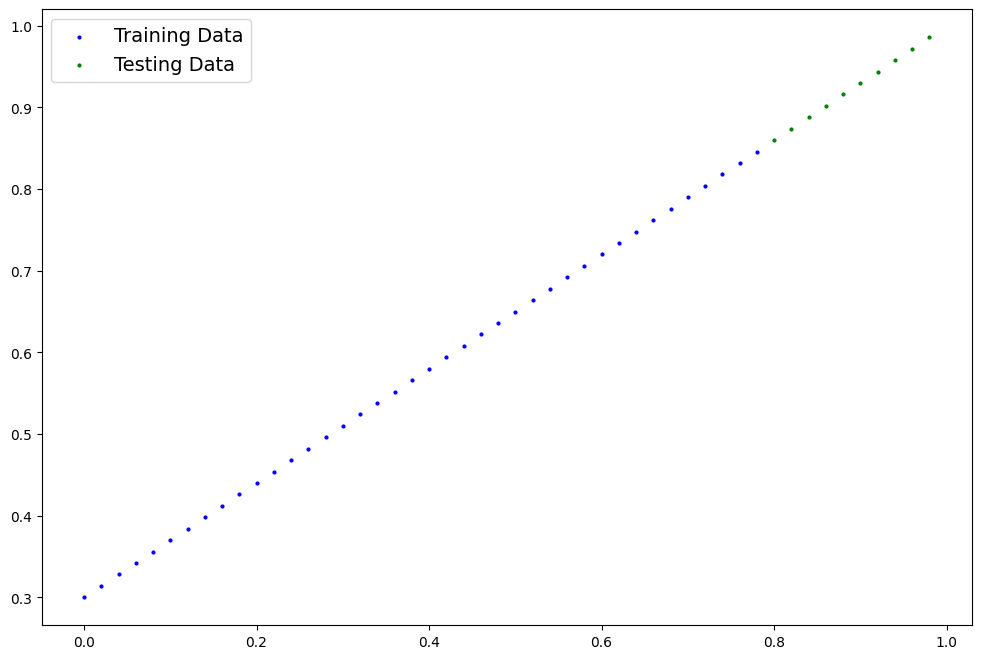

In [5]:
plotPredictions();

In [7]:
# Building a model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights*x + self.bias

In [8]:
torch.manual_seed(42)

model0 = LinearRegressionModel()
list(model0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
model0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

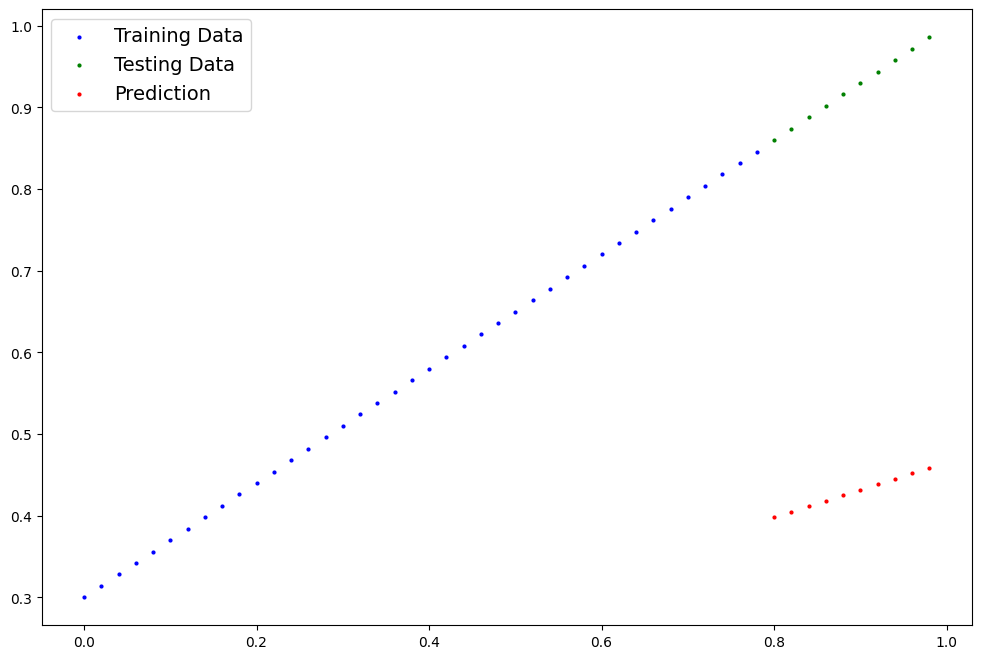

In [10]:
# Making predictions

with torch.inference_mode():
  yPred = model0(XTest)

plotPredictions(predictions=yPred)

In [13]:
# Setting up loss function and optimizer

lossFn = nn.L1Loss()  # MAE loss
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.01)

In [14]:
torch.manual_seed(42)

epochs = 100

trainLossValues = []
testLossValues = []
epochCount = []

for epoch in range(epochs):
  model0.train()
  yPred = model0(XTrain)
  loss = lossFn(yPred, yTrain)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model0.eval()

  with torch.inference_mode():
    testPred = model0(XTest)

    testLoss = lossFn(testPred, yTest.type(torch.float))

    if epoch % 10 == 0:
      epochCount.append(epoch)
      trainLossValues.append(loss.detach().numpy())
      testLossValues.append(testLoss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {testLoss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


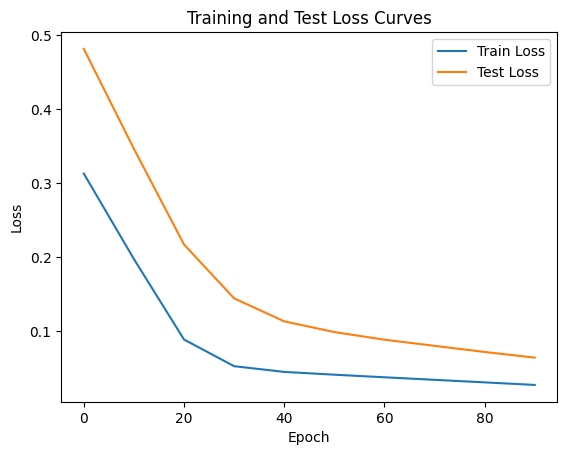

In [15]:
# Plotting the loss curves

plt.plot(epochCount, trainLossValues, label="Train Loss")
plt.plot(epochCount, testLossValues, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

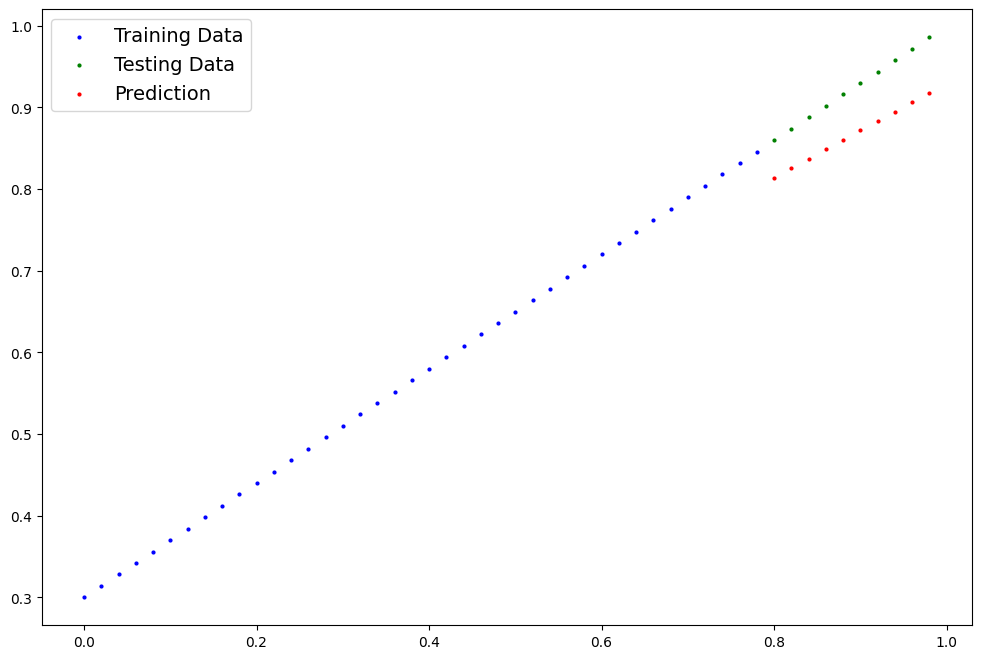

In [16]:
# Making Predictions

model0.eval()

with torch.inference_mode():
  yPred = model0(XTest)

plotPredictions(predictions=yPred)